In [1]:
import pickle 
from py import DiscClass
from py import misc

import galpy
from galpy.potential import IsothermalDiskPotential,turn_physical_off,MWPotential2014,toVerticalPotential, evaluateDensities
from galpy.util.bovy_conversion import dens_in_msolpc3,force_in_2piGmsolpc2,mass_in_msol

import astropy.units as apu

import matplotlib.pyplot as plt
import numpy as np

from galpy.util import bovy_plot
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=16.,xtick_labelsize=14.,ytick_labelsize=14.)

FilePath='/epsen_data/scr/bennett/Sgr-VerticalWaves/'

import importlib
importlib.reload(DiscClass)
importlib.reload(misc)

<module 'py.misc' from '/epsen_data/scr/bennett/Sgr-VerticalWaves/py/misc.py'>

## Import the orbits of Sgr2 in MW2 with 1,2, and 3 pericentre passages as well as the sgr potential

In [2]:
with open(FilePath+'data/Orbits/ModelOrbits/MW1_SGR1_1apo',"rb") as f1,\
     open(FilePath+'data/Orbits/ModelOrbits/MW1_SGR1_2apo',"rb") as f2,\
     open(FilePath+'data/Orbits/ModelOrbits/MW1_SGR1_3apo',"rb") as f3:
    o1 = pickle.load(f1)
    o2 = pickle.load(f2)
    o3 = pickle.load(f3)
    
MLU,MVU,MTU,MMU,MDU,MSDU= misc.get_units(o1)
    
StlrI= 1

with open(FilePath+'data/SgrModel/halo_masses.dat','rb') as f:
    halo_m= np.loadtxt(f)[StlrI]
with open(FilePath+'data/SgrModel/halo_radius.dat','rb') as f:
    halo_a= np.loadtxt(f)[StlrI]
with open(FilePath+'data/SgrModel/stlr_masses.dat','rb') as f:
    stlr_m= np.loadtxt(f)[StlrI]
with open(FilePath+'data/SgrModel/stlr_radius.dat','rb') as f:
    stlr_a= np.loadtxt(f)[StlrI]
    
halo_pot= galpy.potential.HernquistPotential(amp=2.*halo_m*apu.M_sun,a=halo_a*apu.kpc,ro=MLU,vo=MVU) 
stlr_pot= galpy.potential.HernquistPotential(amp=2.*stlr_m*apu.M_sun,a=halo_a*apu.kpc,ro=MLU,vo=MVU) 

sgr_pot= halo_pot+stlr_pot
turn_physical_off(sgr_pot)

### Initialize a simple Isothermal disc
Midplane density $\rho_0= 0.1$ M$_\odot$ pc$^{-3}$   
Vertical velocity dispersion of $v_z=$ 20.5 km s$^{-1}$ taken from Gaia DR2 RV sample in the solar neighbourhood.

In [3]:
p= 0.1/dens_in_msolpc3(MVU,MLU)
mwd= IsothermalDiskPotential(p,20.5/MVU,ro=MLU,vo=MVU)

### Initialize a disc object which we can then perturb using the Isothermal potential
Inputs to disc object:
- times: The times at which to integrate the orbits of each grid point
- zlim and vlim: The grid on which the distribution function is calculated [-zlim,zlim] x [-vlim,vlim]
- zpt and vpt: The number of points in along the z and vz grid respectively

In [4]:
disc= DiscClass.StellarDisc(discpot=[mwd],times=o1.t,zlim=2.,vlim=120.,zpt=100,vpt=50)

### Perturb the disc with a satellite

Inputs to add_satellite function:
- satpot: Potential of the satellite causing the perturbation
- sat: galpy Orbit instance of the satellite
- df_prop: Array or list containing [mid_plane density, velocity dispersion]. Can either be specified in galpy internal units or with astropy units. 
- ftype: 'rotate' or 'static'. Specifies whether or not to include movement of the sun around centre of the galaxy in the model.
    - rotfreq: Specifies orbital frequency of the sun if ftype='rotate'
- tdep: True - Calculate the asymmetry at each time step. False - Calculate the asymmetry only at the final time
- method: 'slowest', 'slow' or 'fast'. Depends on the number of grid points.
- zsun: Method for finding the mid-plane. None - does nnot adjust for midplane. 'fit' - fits an isothermal disc to the density to find mid-plane, 'mean' - calculates the mean zvalue of the density to recover mid-plane position. 


In [5]:
disc.add_satellite(satpot=sgr_pot,sat=o1,df_prop=[[p],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')

### Plot properties of the orbit as well as asymmetry and mean vertical velocity for sample orbit

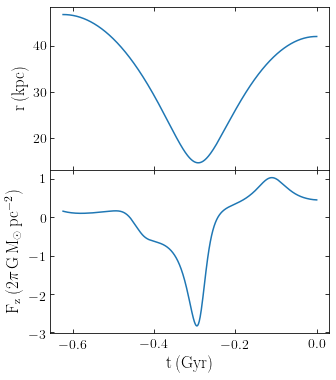

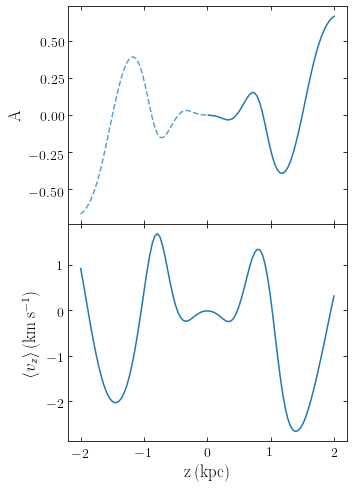

In [6]:
fig,(ax1,ax2)= plt.subplots(2,1,figsize=(5,6),sharex=True)

ax1.plot(o1.t*MTU/1000.,o1.r(o1.t)*MLU)
ax2.plot(disc.t*MTU/1000.,disc.Force[0,0]*force_in_2piGmsolpc2(MVU,MLU))
ax1.set_ylabel(r'$\mathrm{r\,(kpc)}$')
ax2.set_ylabel(r'$\mathrm{F_z\,(2\pi\,G\,M_\odot\,pc^{-2})}$')
ax2.set_xlabel(r'$\mathrm{t\,(Gyr)}$')

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(FilePath+'plots/r_F.pdf',bbox_inches='tight')

fig,(ax1,ax2)= plt.subplots(2,1,figsize=(5,8),sharex=True)
ax1.plot(disc.zA*MLU,disc.A,c='C0')
ax1.plot(-disc.zA*MLU,-disc.A,c='C0',ls='--',alpha=0.7)
ax2.plot(disc.z*MLU,disc.meanV*MVU)
ax1.set_ylabel(r'$\mathrm{A}$')
ax2.set_ylabel(r'$\langle v_{z}\rangle\,\mathrm{(km\,s^{-1})}$')
ax2.set_xlabel(r'$\mathrm{z\,(kpc)}$')

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(FilePath+'plots/A_vz.pdf',bbox_inches='tight')

### Initialize different grid sizes along both the z-axis and v-axis
Add the same satellite perturbation to each disc with different grid sizes

In [7]:
discz100v50= DiscClass.StellarDisc([mwd],zlim=2.,vlim=120.,times=o1.t,zpt=100,vpt=50)
discz100v30= DiscClass.StellarDisc([mwd],zlim=2.,vlim=120.,times=o1.t,zpt=100,vpt=30)
discz100v100= DiscClass.StellarDisc([mwd],zlim=2.,vlim=120.,times=o1.t,zpt=100,vpt=100)

In [8]:
discz50v50= DiscClass.StellarDisc([mwd],zlim=2.,vlim=120.,times=o1.t,zpt=50,vpt=50)
discz200v50= DiscClass.StellarDisc([mwd],zlim=2.,vlim=120.,times=o1.t,zpt=200,vpt=50)

In [9]:
discz100v50.add_satellite(sgr_pot,o1,[[p],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')
discz100v30.add_satellite(sgr_pot,o1,[[p],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')
discz100v100.add_satellite(sgr_pot,o1,[[p],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')
discz50v50.add_satellite(sgr_pot,o1,[[p],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')
discz200v50.add_satellite(sgr_pot,o1,[[p],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')

### Plot the difference in asymmetry for the different grids

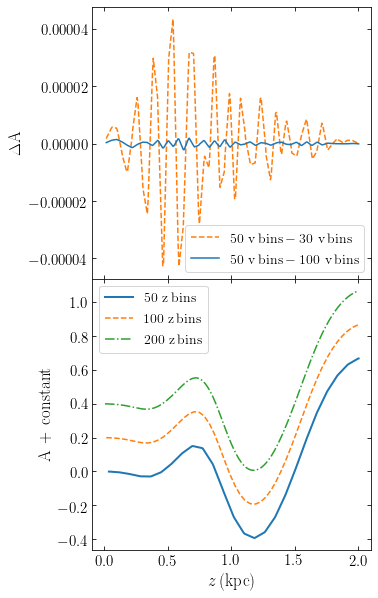

In [10]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=24.,xtick_labelsize=15.,ytick_labelsize=15.,legend_fontsize=14)

fig,(ax1,ax2)= plt.subplots(2,1,sharex=True,figsize=[5,10])
ax1.plot(discz100v50.zA*MLU,(discz100v50.A-discz100v30.A),ls='--',c='C1',label=r'$50\,\,\mathrm{v\,bins}-30\,\,\mathrm{v\,bins}$')
ax1.plot(discz100v50.zA*MLU,(discz100v50.A-discz100v100.A),ls='-',c='C0',label=r'$50\,\,\mathrm{v\,bins}-100\,\,\mathrm{v\,bins}$')
ax1.legend(loc=4)

ax2.plot(discz50v50.zA*MLU,discz50v50.A,ls='-',lw=2,label=r'$50\,\,\mathrm{z\,bins}$')
ax2.plot(discz100v50.zA*MLU,discz100v50.A+0.2,ls='--',label=r'$100\,\,\mathrm{z\,bins}$')
ax2.plot(discz200v50.zA*MLU,discz200v50.A+0.4,ls='-.',label=r'$200\,\,\mathrm{z\,bins}$')
ax2.legend(loc=2)
ax1.set_ylabel(r'$\Delta \mathrm{A}$')
ax2.set_ylabel(r'$\mathrm{A\,+\,constant}$')
ax2.set_xlabel(r'$z\,(\mathrm{kpc})$')

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig(FilePath+'plots/binsTest.pdf',bbox_inches='tight')

Calculate the maximum difference between using different velocity bins. 

In [11]:
percent1= np.max(np.abs((discz100v50.A-discz100v30.A)/discz100v50.A))
percent2= np.max(np.abs((discz100v50.A-discz100v100.A)/discz100v50.A))

print('''The percent difference between using 30 velocity bins 
    and 50 velocity bins is:    ''',
      percent1*100)
print('''The percent difference between using 50 velocity bins 
    and 100 velocity bins is:    ''',
      percent2*100)

The percent difference between using 30 velocity bins 
    and 50 velocity bins is:     2.51072962354535
The percent difference between using 50 velocity bins 
    and 100 velocity bins is:     0.08950232252101682


### Calculate the asymmetry for Orbit with 1, 2, and 3 pericentre passages

In [12]:
disc.add_satellite(sgr_pot,o1,[[p],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')
z1= disc.z
zA1= disc.zA
p1= disc.rho
A1= disc.A
vM1= disc.meanV

disc.add_satellite(sgr_pot,o2,[[p],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')
z2= disc.z
zA2= disc.zA
p2= disc.rho
A2= disc.A
vM2= disc.meanV

disc.add_satellite(sgr_pot,o3,[[p],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')
z3= disc.z
zA3= disc.zA
p3= disc.rho
A3= disc.A
vM3= disc.meanV

Plot the asymmetry for the 3 different pericentre cases.

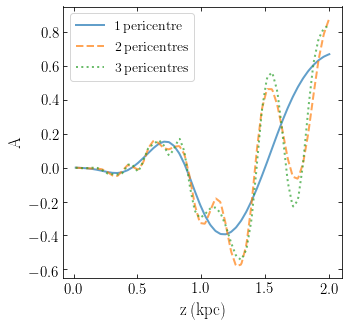

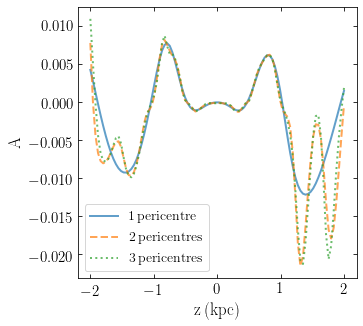

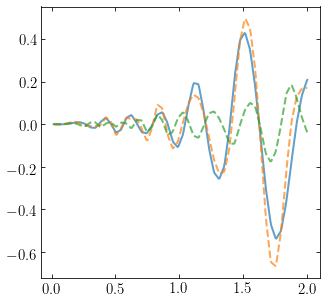

In [13]:
plt.figure()

plt.plot(zA1*MLU,A1,lw=2,ls='-',label=r'$\mathrm{1\,pericentre}$',alpha=0.7)
plt.plot(zA2*MLU,A2,lw=2,ls='--',label=r'$\mathrm{2\,pericentres}$',alpha=0.7)
plt.plot(zA3*MLU,A3,lw=2,ls=':',label=r'$\mathrm{3\,pericentres}$',alpha=0.7)

plt.xlabel(r'$\mathrm{z\,(kpc)}$')
plt.ylabel(r'$\mathrm{A}$')
plt.legend()

plt.savefig(FilePath+'plots/apo_orbits_A.pdf',bbox_inches='tight')

plt.figure()

plt.plot(z1*MLU,vM1,lw=2,ls='-',label=r'$\mathrm{1\,pericentre}$',alpha=0.7)
plt.plot(z2*MLU,vM2,lw=2,ls='--',label=r'$\mathrm{2\,pericentres}$',alpha=0.7)
plt.plot(z3*MLU,vM3,lw=2,ls=':',label=r'$\mathrm{3\,pericentres}$',alpha=0.7)

plt.xlabel(r'$\mathrm{z\,(kpc)}$')
plt.ylabel(r'$\mathrm{A}$')
plt.legend()

plt.figure()
plt.plot(zA1*MLU,A2-A1,lw=2,ls='-',alpha=0.7)
plt.plot(zA2*MLU,A3-A1,lw=2,ls='--',alpha=0.7)
plt.plot(zA2*MLU,A3-A2,lw=2,ls='--',alpha=0.7)

## Investigate how different velocity dispersions of the disc affect the asymmetry

In [15]:
disc.add_satellite(sgr_pot,o1,[[p],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')

In [16]:
f010,rho10,meanV10,zA10,A10= disc.change_Iso([[p],[10./MVU]])
f015,rho15,meanV15,zA15,A15= disc.change_Iso([[p],[15./MVU]])
f020,rho20,meanV20,zA20,A20= disc.change_Iso([[p],[20./MVU]])
f030,rho30,meanV30,zA30,A30= disc.change_Iso([[p],[30./MVU]])
f040,rho40,meanV40,zA40,A40= disc.change_Iso([[p],[40./MVU]])

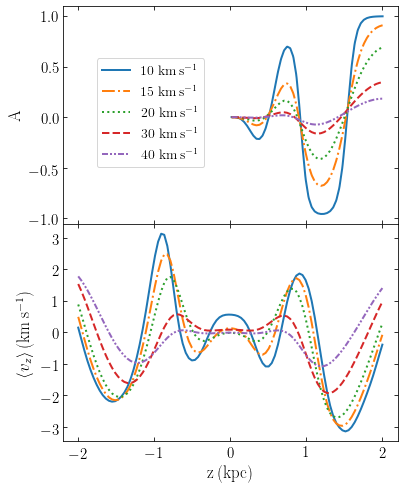

In [18]:
fig,[ax1,ax2]= plt.subplots(2,1,figsize=[6,8],sharex=True)

ax1.plot(zA10*MLU,A10,lw=2,c='C0',label=r'$10\,\, \mathrm{km\,s^{-1}}$')
ax1.plot(zA15*MLU,A15,lw=2,c='C1',ls='-.',label=r'$15\,\, \mathrm{km\,s^{-1}}$')
ax1.plot(zA20*MLU,A20,lw=2,c='C2',ls=':',label=r'$20\,\, \mathrm{km\,s^{-1}}$')
ax1.plot(zA30*MLU,A30,lw=2,c='C3',ls='--',label=r'$30\,\, \mathrm{km\,s^{-1}}$')
ax1.plot(zA40*MLU,A40,lw=2,c='C4',ls=(0, (3, 1, 1, 1, 1, 1)),label=r'$40\,\, \mathrm{km\,s^{-1}}$')

ax1.set_ylabel(r'$\mathrm{A}$')
ax1.legend(bbox_to_anchor=(0.1, .66, 1., .102), loc='upper left',
           ncol=1, borderaxespad=0.)

ax2.plot(disc.z*MLU,meanV10*MVU,lw=2,c='C0',label=r'$10\,\, \mathrm{km\,s^{-1}}$')
ax2.plot(disc.z*MLU,meanV15*MVU,lw=2,c='C1',ls='-.',label=r'$15\,\, \mathrm{km\,s^{-1}}$')
ax2.plot(disc.z*MLU,meanV20*MVU,lw=2,c='C2',ls=':',label=r'$20\,\, \mathrm{km\,s^{-1}}$')
ax2.plot(disc.z*MLU,meanV30*MVU,lw=2,c='C3',ls='--',label=r'$30\,\, \mathrm{km\,s^{-1}}$')
ax2.plot(disc.z*MLU,meanV40*MVU,lw=2,c='C4',ls=(0, (3, 1, 1, 1, 1, 1)),label=r'$40\,\, \mathrm{km\,s^{-1}}$')
ax2.set_xlabel(r'$\mathrm{z\,(kpc)}$')
ax2.set_ylabel(r'$\langle v_{z}\rangle\,\mathrm{(km\,s^{-1})}$')

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig(FilePath+'plots/VD_pert.pdf',bbox_inches='tight')

### Look at how changing the mid-plane density affects the asymmetry

Set-up five isothermal discs with varying mid-plane densities and use them to initialise five disc objects.

In [23]:
p08= 0.08/dens_in_msolpc3(MVU,MLU)
p09= 0.09/dens_in_msolpc3(MVU,MLU)
p10= 0.10/dens_in_msolpc3(MVU,MLU)
p11= 0.11/dens_in_msolpc3(MVU,MLU)
p12= 0.12/dens_in_msolpc3(MVU,MLU)

mwp08= IsothermalDiskPotential(p08,20.5/MVU)
mwp09= IsothermalDiskPotential(p09,20.5/MVU)
mwp10= IsothermalDiskPotential(p10,20.5/MVU)
mwp11= IsothermalDiskPotential(p11,20.5/MVU)
mwp12= IsothermalDiskPotential(p12,20.5/MVU)

disc08= DiscClass.StellarDisc([mwp08],zlim=2.,vlim=120.,times=o1.t,zpt=100,vpt=50)
disc09= DiscClass.StellarDisc([mwp09],zlim=2.,vlim=120.,times=o1.t,zpt=100,vpt=50)
disc10= DiscClass.StellarDisc([mwp10],zlim=2.,vlim=120.,times=o1.t,zpt=100,vpt=50)
disc11= DiscClass.StellarDisc([mwp11],zlim=2.,vlim=120.,times=o1.t,zpt=100,vpt=50)
disc12= DiscClass.StellarDisc([mwp12],zlim=2.,vlim=120.,times=o1.t,zpt=100,vpt=50)

Add the perturbation to all five discs

In [24]:
disc08.add_satellite(sgr_pot,o1,[[p08],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')
disc09.add_satellite(sgr_pot,o1,[[p09],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')
disc10.add_satellite(sgr_pot,o1,[[p10],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')
disc11.add_satellite(sgr_pot,o1,[[p11],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')
disc12.add_satellite(sgr_pot,o1,[[p12],[20.5/MVU]],ftype='rotate',tdep=False,method='slow',zsun='fit')

Plot the asymmetry and mean vertical velocities for the different discs.

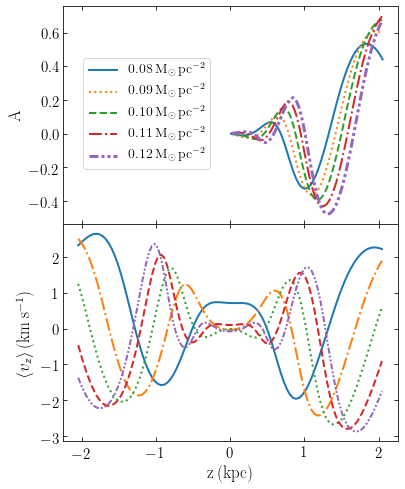

In [26]:
fig,[ax1,ax2]= plt.subplots(2,1,figsize=[6,8],sharex=True)

ax1.plot(disc08.zA*MLU,disc08.A,lw=2,c='C0',label=r'$0.08\,\mathrm{M_\odot\,pc^{-2}}$')
ax1.plot(disc09.zA*MLU,disc09.A,lw=2,c='C1',ls=':',label=r'$0.09\,\mathrm{M_\odot\,pc^{-2}}$')
ax1.plot(disc10.zA*MLU,disc10.A,lw=2,c='C2',ls='--',label=r'$0.10\,\mathrm{M_\odot\,pc^{-2}}$')
ax1.plot(disc11.zA*MLU,disc11.A,lw=2,c='C3',ls='-.',label=r'$0.11\,\mathrm{M_\odot\,pc^{-2}}$')
ax1.plot(disc12.zA*MLU,disc12.A,lw=3,c='C4',
         ls=(0, (3, 1, 1, 1, 1, 1)),label=r'$0.12\,\mathrm{M_\odot\,pc^{-2}}$')

ax1.legend(bbox_to_anchor=(0.06, .66, 1., .102), loc='upper left',
           ncol=1, borderaxespad=0.)

ax2.plot(disc08.z*MLU,disc06.meanV[:,0]*MVU,lw=2,c='C0',label=r'$0.08\,\mathrm{M_\odot\,pc^{-3}}$')
ax2.plot(disc09.z*MLU,disc08.meanV[:,0]*MVU,lw=2,c='C1',ls='-.',label=r'$0.09\,\mathrm{M_\odot\,pc^{-3}}$')
ax2.plot(disc10.z*MLU,disc10.meanV[:,0]*MVU,lw=2,c='C2',ls=':',label=r'$0.10\,\mathrm{M_\odot\,pc^{-3}}$')
ax2.plot(disc11.z*MLU,disc12.meanV[:,0]*MVU,lw=2,c='C3',ls='--',label=r'$0.11\,\mathrm{M_\odot\,pc^{-3}}$')
ax2.plot(disc12.z*MLU,disc14.meanV[:,0]*MVU,lw=2,c='C4',ls=(0, (3, 1, 1, 1, 1, 1)),label=r'$0.12\,\mathrm{M_\odot\,pc^{-3}}$')

ax2.set_xlabel(r'$\mathrm{z\,(kpc)}$')
ax1.set_ylabel(r'$\mathrm{A}$')
ax2.set_ylabel(r'$\langle v_{z}\rangle\,\mathrm{(km\,s^{-1})}$')

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig(FilePath+'plots/MD_pert.pdf',bbox_inches='tight')